В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [28]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

In [29]:
def drawRocAuc(y_test, y_pred_proba):
    # Вычисление ROC-кривой и AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Построение ROC-кривой
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Подготовка датасета

In [30]:
data = pd.read_csv('weather.csv')

train_data, test_data = train_test_split(data, shuffle=False, test_size=0.25)
y_train = train_data.RainTomorrow.replace({'No':0, 'Yes': 1})
y_test = test_data.RainTomorrow.replace({'No':0, 'Yes': 1})

x_train = train_data
x_test = test_data

del x_train['RainTomorrow']
del x_test['RainTomorrow']

x_train.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No


## Функция обучения.
Использует SimpleImputer для заполнения пропусков в количественных и категориальных признаках. Также нормализует количественные данные и применяет OneHotEncoder или LabelEncoder для категориальных. OHE не подходит для GaussianNB, т.к. создает разреженную матрицу.

In [31]:
def trainModel(x_train, y_train, x_test, y_test, model, ohe=True, roc_auc=False):
    numeric_features = x_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = x_train.select_dtypes(include=[object]).columns.tolist()
    transformers = []

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    transformers.append(('num', numeric_transformer, numeric_features))
    if ohe:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Not given')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        transformers.append(("cat", categorical_transformer, categorical_features))
    else:
        x_train[categorical_features] = x_train[categorical_features].fillna("NotGiven")
        x_test[categorical_features] = x_test[categorical_features].fillna("NotGiven")    
        le = LabelEncoder()
        for feature in categorical_features:
            x_train[feature] = le.fit_transform(x_train[feature])
            x_test[feature] = le.fit_transform(x_test[feature])

    preprocessor = ColumnTransformer(
        transformers=transformers
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    model = pipeline.fit(x_train, y_train)

    if roc_auc:
        y_pred_proba = model.predict_proba(x_test)[:, 1]
        drawRocAuc(y_test, y_pred_proba)

    y_predict = model.predict(x_test)
    print(classification_report(y_test, y_predict))

## 1.1 Логистическая регрессия

In [32]:
model = LogisticRegression()
trainModel(x_train, y_train, x_test, y_test, model)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     27882
           1       0.70      0.47      0.56      7667

    accuracy                           0.84     35549
   macro avg       0.78      0.71      0.73     35549
weighted avg       0.83      0.84      0.83     35549



## 1.2 Классификатор на основе метода KNN

In [33]:
model = KNeighborsClassifier(n_neighbors=1)
trainModel(x_train, y_train, x_test, y_test, model, ohe=False)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     27882
           1       0.53      0.50      0.51      7667

    accuracy                           0.80     35549
   macro avg       0.70      0.69      0.69     35549
weighted avg       0.79      0.80      0.79     35549



## 1.3 Наивный Байесовский классификатор

In [34]:
model = GaussianNB()
trainModel(x_train, y_train, x_test, y_test, model, False)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     27882
           1       0.63      0.56      0.59      7667

    accuracy                           0.83     35549
   macro avg       0.75      0.73      0.74     35549
weighted avg       0.83      0.83      0.83     35549



## 1.4 Логистическая регрессия, реализованная самостоятельно

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [35]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [36]:
def probability(theta, X):
    result = 1 / (1 + np.exp(-np.dot(X, theta)))
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [37]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = np.round(prob).astype(np.number)
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [38]:
def logloss(theta, X, y):
    prob = probability(theta, X)
    result = np.mean(-y * np.log(prob) - (1-y) * np.log(1 - prob))
    return result

In [39]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [40]:
def gradient(theta, X, y):
    result = np.dot((probability(theta, X) - y), X)
    
    return result 

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [41]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [42]:
X, y = make_classification(n_samples=2000)

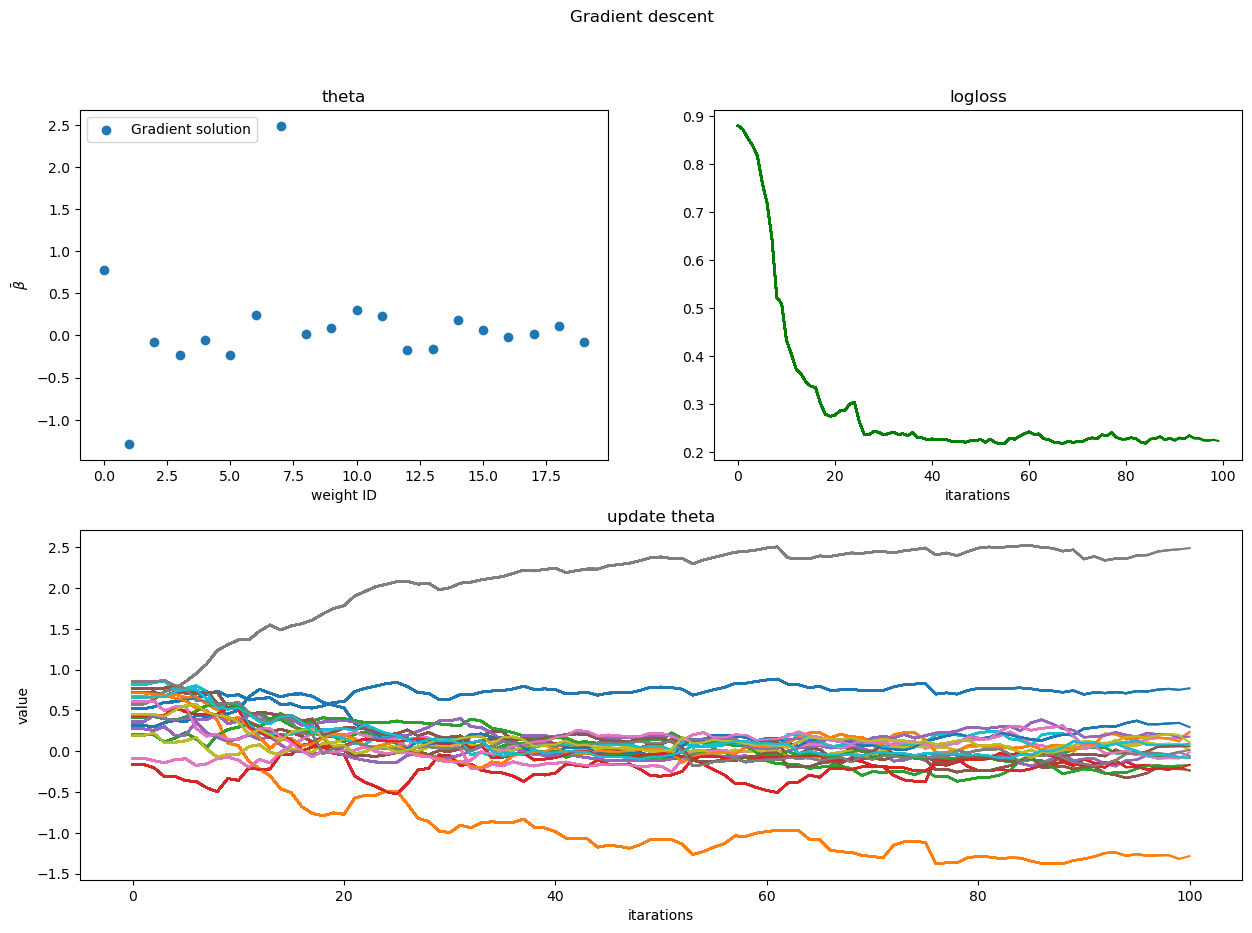

In [43]:
optimal_theta = fit(X, y)

In [44]:
y_pred = binary_class_prediction(optimal_theta, X)

## Функция обучения своей логистической регрессии

In [45]:
def ownFunctionPrediction(x_train, y_train, x_test, y_test, iteration_count=100, plot=False, transforms=False, roc_auc=False):
    if transforms:
        numeric_features = x_train.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = x_train.select_dtypes(include=[object]).columns.tolist()
        transformers = []

        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num', numeric_transformer, numeric_features))

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Not given')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        transformers.append(("cat", categorical_transformer, categorical_features))

        preprocessor = ColumnTransformer(
            transformers=transformers
        )

        x_train = preprocessor.fit_transform(x_train)
        x_test = preprocessor.transform(x_test)
    
    optimal_weights = fit(x_train, y_train, iters=iteration_count, plot=plot)

    y_pred = binary_class_prediction(optimal_weights, x_test)

    if roc_auc:
        drawRocAuc(y_test, y_pred)
    print(classification_report(y_test, y_pred))

При работе модели с разным количеством итераций видим, что 40 - 60 итераций достаточно для сходимости весов

In [46]:
iters = [10, 20, 40, 60, 80, 100]

for iteration_count in iters:
    print(f"Iteration number is: {iteration_count}")
    ownFunctionPrediction(X, y, X, y, iteration_count=iteration_count)

Iteration number is: 10
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1008
           1       0.82      0.79      0.80       992

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000

Iteration number is: 20
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1008
           1       0.92      0.89      0.90       992

    accuracy                           0.91      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.91      0.90      2000

Iteration number is: 40
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1008
           1       0.92      0.88      0.90       992

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
we

Результат собственной логистической регрессии на датасете из weather.csv

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     27882
           1       0.42      0.81      0.55      7667

    accuracy                           0.71     35549
   macro avg       0.67      0.75      0.67     35549
weighted avg       0.82      0.71      0.74     35549



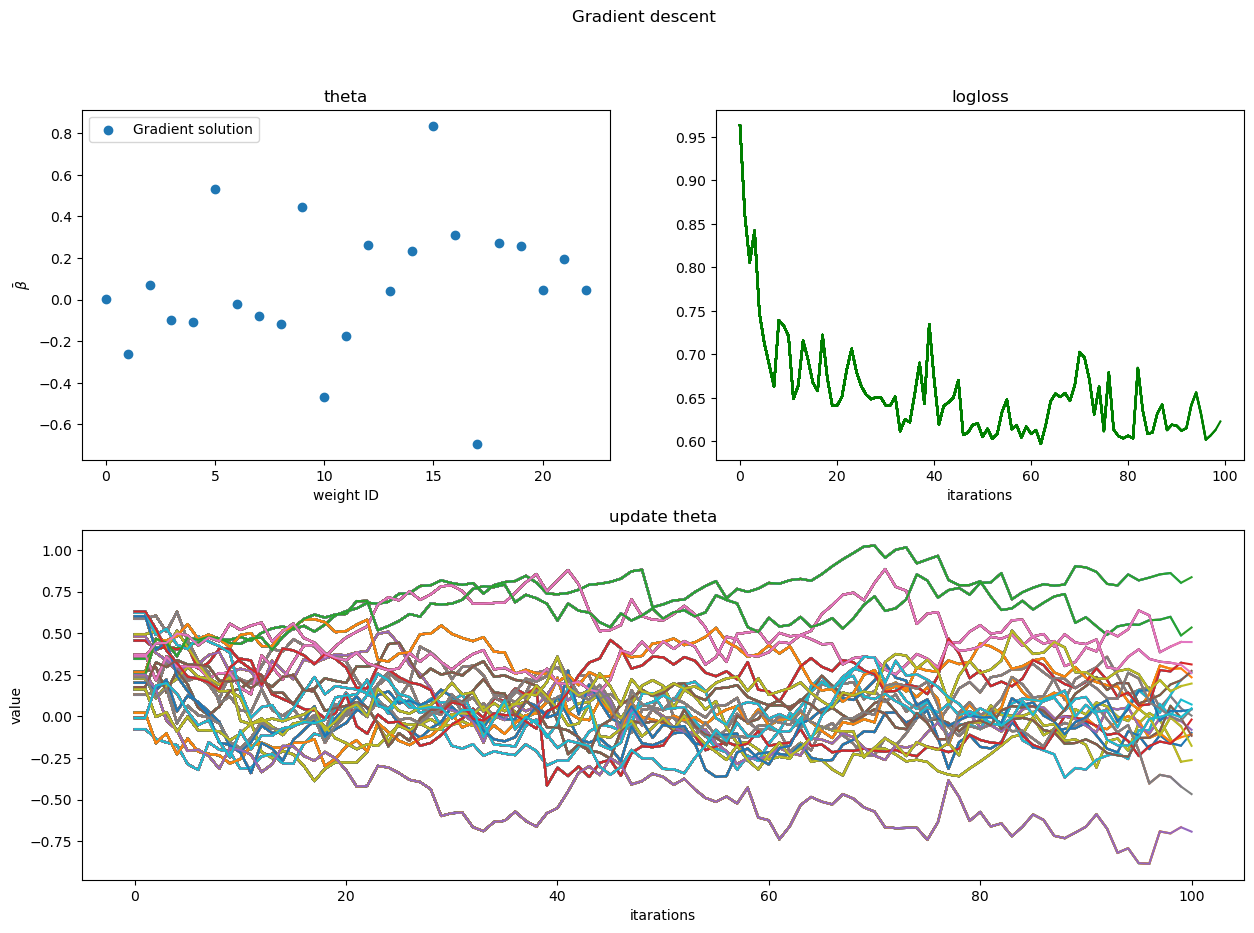

In [47]:
ownFunctionPrediction(x_train, y_train, x_test, y_test, iteration_count=100, plot=True, transforms=True)

## 2 Приведем результаты работ всех реализованных моделей

1. LogisticRegression


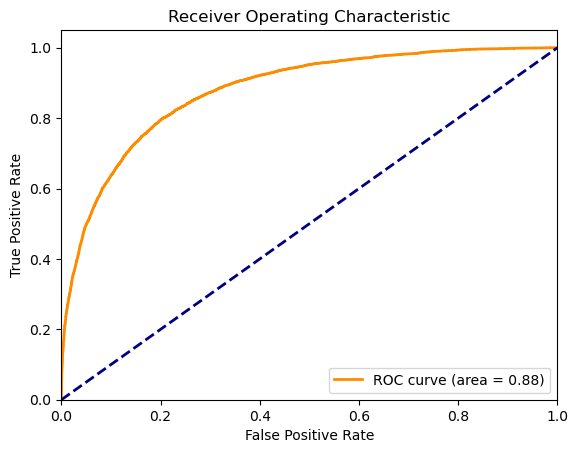

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     27882
           1       0.75      0.46      0.57      7667

    accuracy                           0.85     35549
   macro avg       0.81      0.71      0.74     35549
weighted avg       0.84      0.85      0.84     35549

2. KNeighborsClassifier


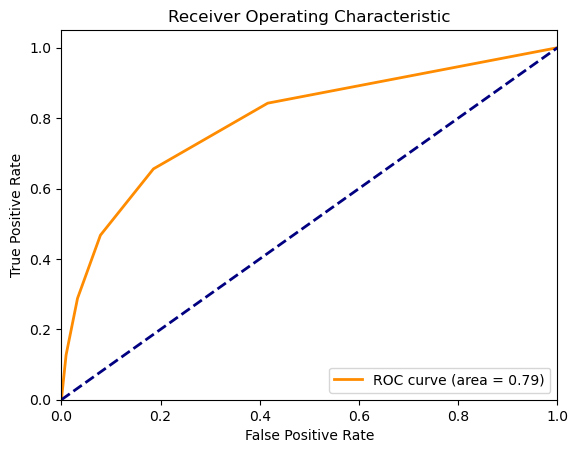

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     27882
           1       0.62      0.47      0.53      7667

    accuracy                           0.82     35549
   macro avg       0.74      0.69      0.71     35549
weighted avg       0.81      0.82      0.81     35549

3. GaussianNB


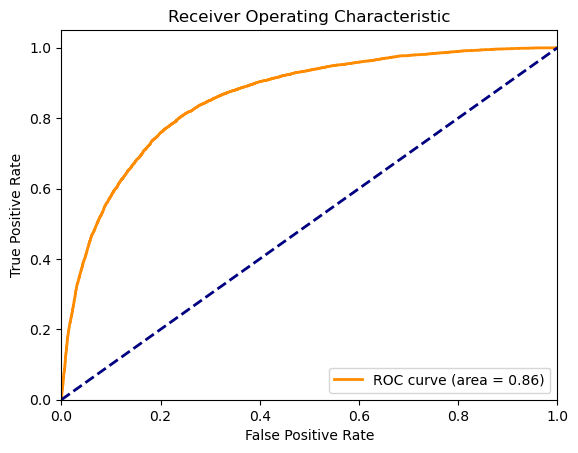

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     27882
           1       0.63      0.56      0.59      7667

    accuracy                           0.83     35549
   macro avg       0.75      0.73      0.74     35549
weighted avg       0.83      0.83      0.83     35549

4. Own LogisticRegression


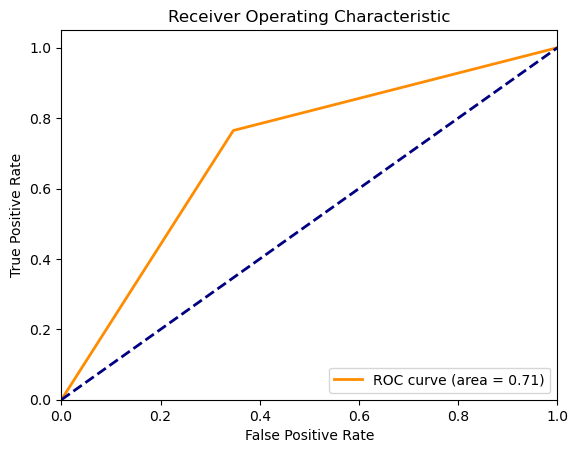

              precision    recall  f1-score   support

           0       0.91      0.65      0.76     27882
           1       0.38      0.76      0.51      7667

    accuracy                           0.68     35549
   macro avg       0.64      0.71      0.63     35549
weighted avg       0.80      0.68      0.71     35549



In [48]:
builtin_models = [{"model": LogisticRegression(), "ohe": True},
                   {"model": KNeighborsClassifier(n_neighbors=5), "ohe": False},
                   {"model": GaussianNB(), "ohe": False},
                   ]
count = 0
for idx, model in enumerate(builtin_models):
    count += 1
    print(f"{idx + 1}. {type(model['model']).__name__}")
    trainModel(x_train, y_train, x_test, y_test, model["model"], model["ohe"], roc_auc=True)

print(f"{count + 1}. Own LogisticRegression")
ownFunctionPrediction(x_train, y_train, x_test, y_test, iteration_count=100, plot=False, transforms=True, roc_auc=True)

## Выводы

1. Результаты работы библиотечных моделей более или менее идентичны. KNN может улучшить свою работу при подборе оптимального гиперпараметра k. Единственное, что можно выделить, KNN очень долго работает с OneHotEncoder из-за большого количества параметров после преобразования; GaussianNB работает с нормализованными данными, причем данные должны быть представлены не разреженной матрицей;
2. Наиболее точная и оптимальная модель в плане предсказаний и затрат времени - LogisticRegression;
3. Логистическая регрессия, построенная самостоятельно явялется самой затратной по времени и самой неточной из рассматриваемых.